<a href="https://colab.research.google.com/github/parmesh-iitkgp/Car-Brand-Type-Classification/blob/main/CarBrand%26TypeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Google Drive Import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Parameters**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_1 = 20
EPOCHS_2 = 20

**Paths**

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Python/train_data"
CSV_PATH  = "/content/drive/MyDrive/Python/train_data.csv"

**Load CSV and Encode Labels**

In [ ]:
df = pd.read_csv(CSV_PATH)

In [ ]:
brand_encoder = LabelEncoder()
type_encoder  = LabelEncoder()

In [ ]:
df["Brand_enc"] = brand_encoder.fit_transform(df["Brand"])
df["Type_enc"]  = type_encoder.fit_transform(df["Type"])

In [ ]:
NUM_BRANDS = df["Brand_enc"].nunique()
NUM_TYPES  = df["Type_enc"].nunique()

In [ ]:
print("Brands:", brand_encoder.classes_)
print("Types :", type_encoder.classes_)

Brands: ['Honda' 'Hyundai' 'Mercedes-Benz']
Types : ['Convertible' 'Hatchback' 'Sedan']


**Image Loader with Bounding Box Cropping**

Box **Plot**

In [ ]:
def load_and_crop(row):
    img_path = os.path.join(IMAGE_DIR, row["file_name"])
    img = cv2.imread(img_path)

    # Image not found or unreadable
    if img is None:
        return None

    h, w, _ = img.shape

    # Read bbox safely
    x1 = int(row["bbox_x1"])
    y1 = int(row["bbox_y1"])
    x2 = int(row["bbox_x2"])
    y2 = int(row["bbox_y2"])

    # Fix inverted coordinates
    x_min = max(0, min(x1, x2))
    y_min = max(0, min(y1, y2))
    x_max = min(w, max(x1, x2))
    y_max = min(h, max(y1, y2))

    # Check for valid box
    if x_max <= x_min or y_max <= y_min:
        return None

    crop = img[y_min:y_max, x_min:x_max]

    # Crop sanity check
    if crop.size == 0:
        return None

    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = crop / 255.0

    return crop


**Add Debug Counter**

In [ ]:
images = []
brand_labels = []
type_labels = []
skipped = 0

for _, row in df.iterrows():
    img = load_and_crop(row)
    if img is not None:
        images.append(img)
        brand_labels.append(row["Brand_enc"])
        type_labels.append(row["Type_enc"])
    else:
        skipped += 1

print("Valid images:", len(images))
print("Skipped images:", skipped)

X = np.array(images, dtype="float32")
y_brand = tf.keras.utils.to_categorical(brand_labels, NUM_BRANDS)
y_type  = tf.keras.utils.to_categorical(type_labels,  NUM_TYPES)

print("Dataset shape:", X.shape)


Valid images: 470
Skipped images: 8
Dataset shape: (470, 224, 224, 3)


Train / Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, yb_train, yb_val, yt_train, yt_val = train_test_split(
    X, y_brand, y_type, test_size=0.2, random_state=42
)

**EfficientNetB0 Multi-Head Model (Brand + Type)**

In [ ]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

brand_out = Dense(NUM_BRANDS, activation="softmax", name="brand")(x)
type_out  = Dense(NUM_TYPES,  activation="softmax", name="type")(x)

model = Model(inputs, [brand_out, type_out])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,708,521 (17.96 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

**Callbacks**

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2)
]


**Metrics**

In [ ]:
model.compile(
    optimizer="adam",
    loss={
        "brand": "categorical_crossentropy",
        "type":  "categorical_crossentropy"
    },
    metrics={
        "brand": "accuracy",
        "type":  "accuracy"
    }
)


**Phase-1 Training**

In [ ]:
history1 = model.fit(
    X_train,
    [yb_train, yt_train],
    validation_data=(X_val, [yb_val, yt_val]),
    epochs=EPOCHS_1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - brand_accuracy: 0.5526 - brand_loss: 0.9545 - loss: 1.8712 - type_accuracy: 0.7179 - type_loss: 0.9160 - val_brand_accuracy: 0.5957 - val_brand_loss: 0.8615 - val_loss: 1.5420 - val_type_accuracy: 0.7660 - val_type_loss: 0.6790 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - brand_accuracy: 0.5798 - brand_loss: 0.9191 - loss: 1.7180 - type_accuracy: 0.7277 - type_loss: 0.7999 - val_brand_accuracy: 0.5957 - val_brand_loss: 0.8622 - val_loss: 1.5412 - val_type_accuracy: 0.7660 - val_type_loss: 0.6785 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - brand_accuracy: 0.4951 - brand_loss: 0.9227 - loss: 1.7091 - type_accuracy: 0.7317 - type_loss: 0.7863 - val_brand_accuracy: 0.5957 - val_brand_loss: 0.8576 - val_loss: 1.5353 - val_type_accuracy: 0.7660 - val_type_loss: 0.6768 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - brand_accuracy: 0.5521 - brand_loss:

**Phase-2 Fine Tuning**

In [ ]:
# Unfreeze top layers
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Re-compile CORRECTLY for multi-output model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "brand": "categorical_crossentropy",
        "type":  "categorical_crossentropy"
    },
    metrics={
        "brand": "accuracy",
        "type":  "accuracy"
    }
)

# Fine-tuning
history2 = model.fit(
    X_train,
    [yb_train, yt_train],
    validation_data=(X_val, [yb_val, yt_val]),
    epochs=EPOCHS_2,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - brand_accuracy: 0.4736 - brand_loss: 1.0329 - loss: 1.9598 - type_accuracy: 0.6997 - type_loss: 0.9266 - val_brand_accuracy: 0.5957 - val_brand_loss: 0.8526 - val_loss: 1.5242 - val_type_accuracy: 0.7660 - val_type_loss: 0.6707 - learning_rate: 1.0000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - brand_accuracy: 0.5629 - brand_loss: 0.9136 - loss: 1.6629 - type_accuracy: 0.7546 - type_loss: 0.7495 - val_brand_accuracy: 0.5957 - val_brand_loss: 0.8551 - val_loss: 1.5277 - val_type_accuracy: 0.7660 - val_type_loss: 0.6719 - learning_rate: 1.0000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - brand_accuracy: 0.5906 - brand_loss: 0.8964 - loss: 1.6315 - type_accuracy: 0.7595 - type_loss: 0.7353 - val_brand_accuracy: 0.5957 - val_brand_loss: 0.8558 - val_loss: 1.5277 - val_type_accuracy: 0.7660 - val_type_loss: 0.6712 - learning_rate: 1.0000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - brand_accuracy: 0.5486 -

**Fine-Tuning Curves**

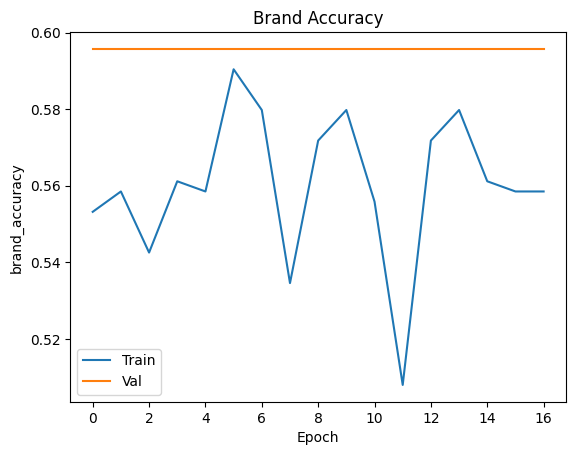

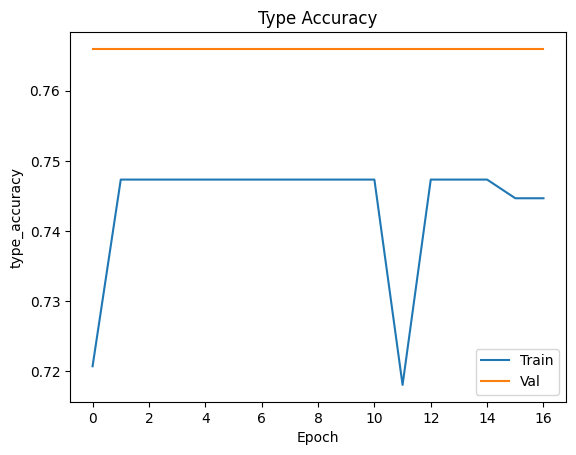

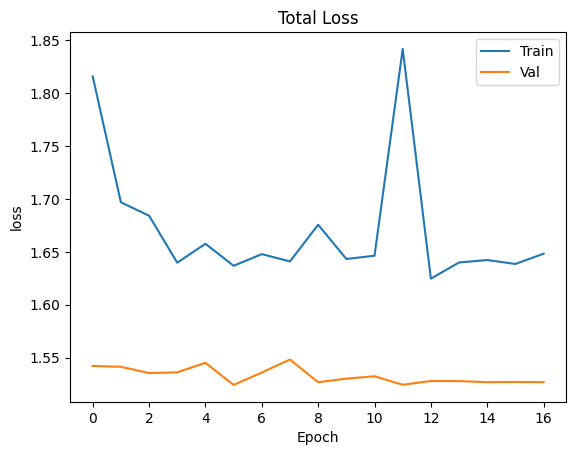

In [ ]:
def plot_curve(h1, h2, key, title):
    plt.plot(h1.history[key] + h2.history[key])
    plt.plot(h1.history["val_"+key] + h2.history["val_"+key])
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend(["Train","Val"])
    plt.show()

plot_curve(history1, history2, "brand_accuracy", "Brand Accuracy")
plot_curve(history1, history2, "type_accuracy",  "Type Accuracy")
plot_curve(history1, history2, "loss", "Total Loss")


**Confusion Metrix (Brand and Type)**

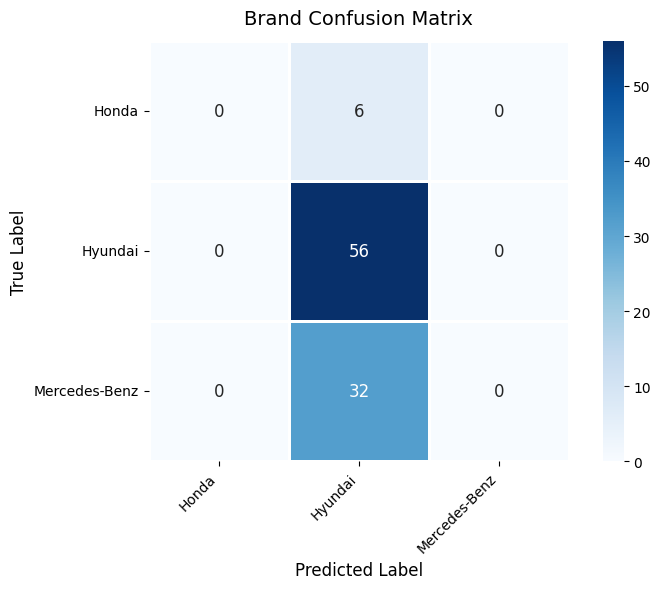

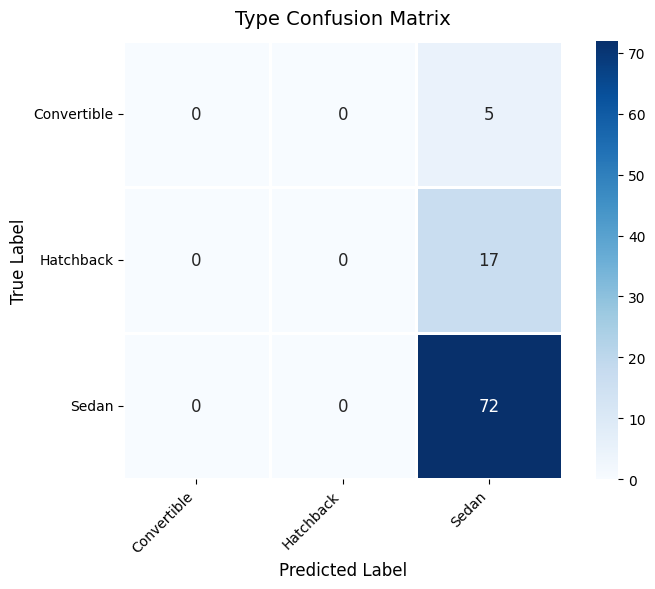

In [ ]:
def plot_clean_confusion_matrix(
    cm,
    class_names,
    title,
    cmap="Blues"
):
    plt.figure(figsize=(8, 6))

    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=True,
        linewidths=1,
        linecolor="white",
        square=True,
        annot_kws={"size": 12}
    )

    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names, rotation=0)

    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title(title, fontsize=14, pad=12)

    plt.tight_layout()
    plt.show()


# Brand
plot_clean_confusion_matrix(
    cm_brand,
    brand_encoder.classes_,
    title="Brand Confusion Matrix",
    cmap="Blues"
)

# Type
plot_clean_confusion_matrix(
    cm_type,
    type_encoder.classes_,
    title="Type Confusion Matrix",
    cmap="Blues"
)


**Percentage Accuracy per Class**

In [ ]:
def plot_clean_confusion_matrix(
    cm,
    class_names,
    title,
    cmap="Blues",
    normalized=False
):
    plt.figure(figsize=(8, 6))

    fmt = ".2f" if normalized else "d"

    ax = sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        cbar=True,
        linewidths=1,
        linecolor="white",
        square=True,
        annot_kws={"size": 12}
    )

    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names, rotation=0)

    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title(title, fontsize=14, pad=12)

    plt.tight_layout()
    plt.show()


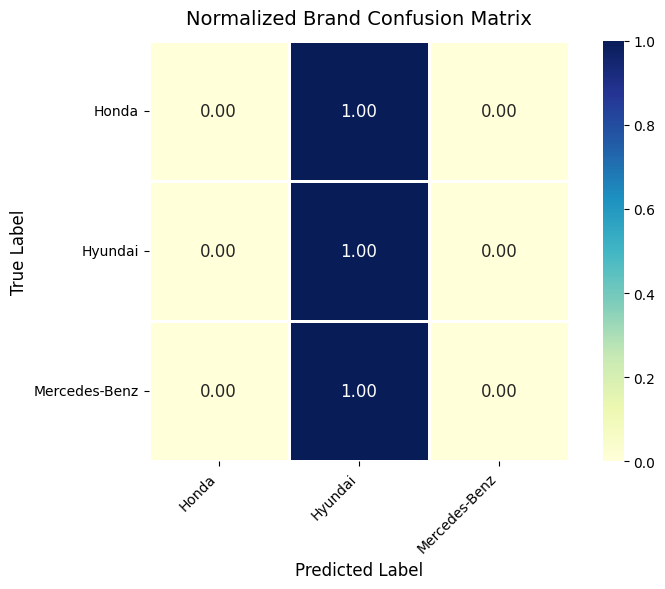

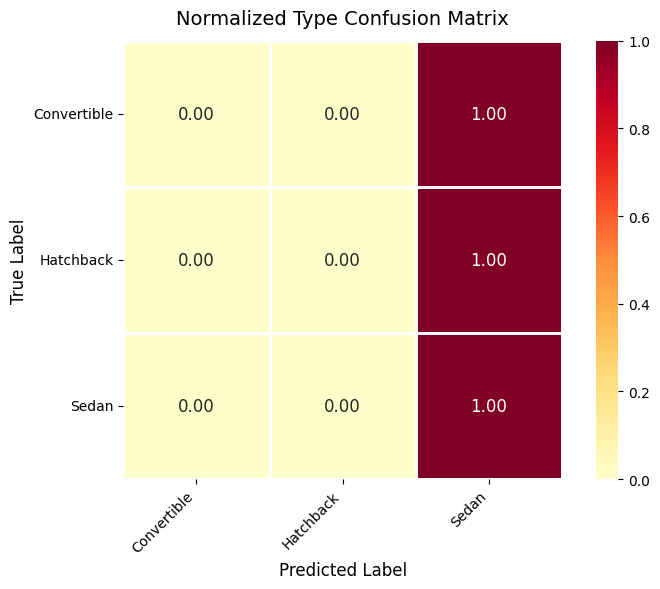

In [ ]:
cm_brand_norm = cm_brand.astype("float") / cm_brand.sum(axis=1)[:, np.newaxis]

plot_clean_confusion_matrix(
    cm_brand_norm,
    brand_encoder.classes_,
    title="Normalized Brand Confusion Matrix",
    cmap="YlGnBu",
    normalized=True
)


cm_type_norm = cm_type.astype("float") / cm_type.sum(axis=1)[:, np.newaxis]

plot_clean_confusion_matrix(
    cm_type_norm,
    type_encoder.classes_,
    title="Normalized Type Confusion Matrix",
    cmap="YlOrRd",
    normalized=True
)


**Show Confusion Matrics (Brands and Types) Both Side-By-Side**

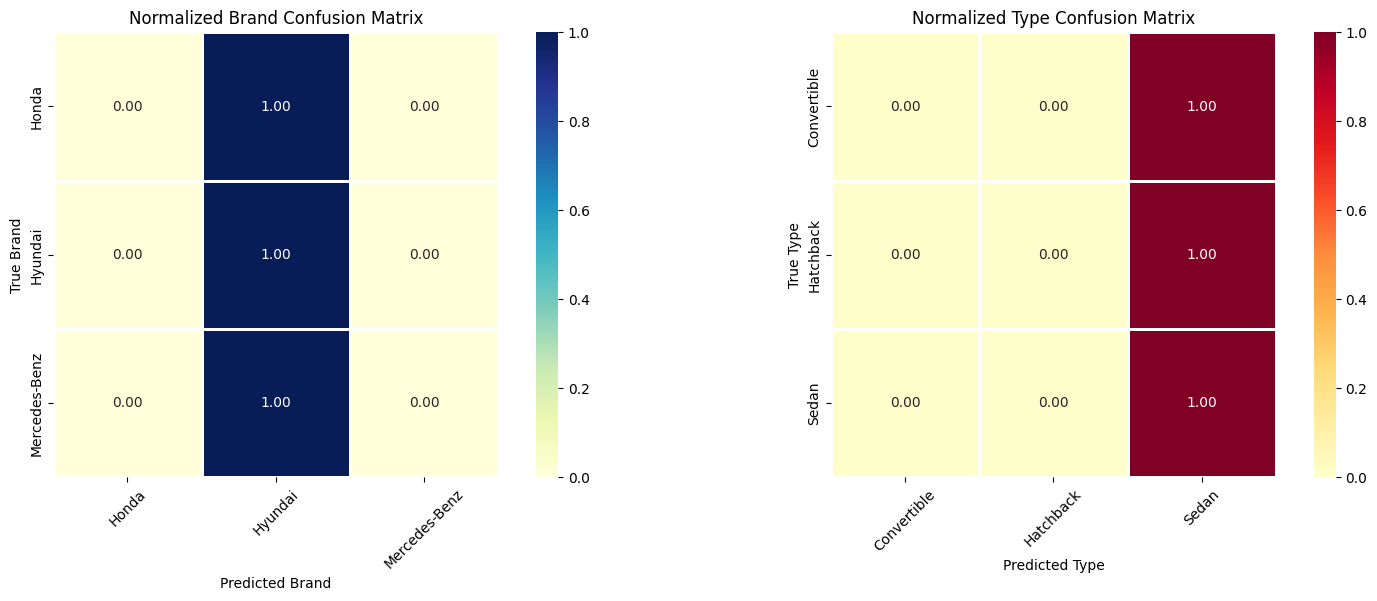

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Brand
sns.heatmap(
    cm_brand_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=1,
    linecolor="white",
    square=True,
    ax=axes[0],
    xticklabels=brand_encoder.classes_,
    yticklabels=brand_encoder.classes_
)
axes[0].set_title("Normalized Brand Confusion Matrix")
axes[0].set_xlabel("Predicted Brand")
axes[0].set_ylabel("True Brand")
axes[0].tick_params(axis="x", rotation=45)

# Type
sns.heatmap(
    cm_type_norm,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=1,
    linecolor="white",
    square=True,
    ax=axes[1],
    xticklabels=type_encoder.classes_,
    yticklabels=type_encoder.classes_
)
axes[1].set_title("Normalized Type Confusion Matrix")
axes[1].set_xlabel("Predicted Type")
axes[1].set_ylabel("True Type")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


**Brand per-class accuracy**

In [ ]:
# Per-class accuracy (Brand)
brand_correct = np.diag(cm_brand)
brand_total   = cm_brand.sum(axis=1)
brand_acc     = brand_correct / brand_total

brand_acc_df = pd.DataFrame({
    "Brand": brand_encoder.classes_,
    "Accuracy": brand_acc
}).sort_values(by="Accuracy", ascending=False)

brand_acc_df

,Brand,Accuracy
1,Hyundai,1.0
0,Honda,0.0
2,Mercedes-Benz,0.0


**Type per-class Accuracy**

In [ ]:
# Per-class accuracy (Type)
type_correct = np.diag(cm_type)
type_total   = cm_type.sum(axis=1)
type_acc     = type_correct / type_total

type_acc_df = pd.DataFrame({
    "Type": type_encoder.classes_,
    "Accuracy": type_acc
}).sort_values(by="Accuracy", ascending=False)

type_acc_df


,Type,Accuracy
2,Sedan,1.0
0,Convertible,0.0
1,Hatchback,0.0


**Brand Accuracy Bar Chart**

/tmp/ipython-input-1524205853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


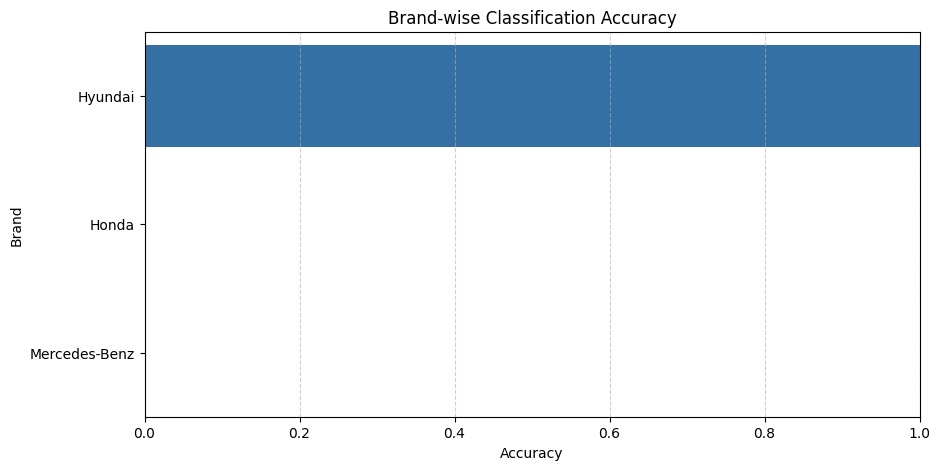

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x="Accuracy",
    y="Brand",
    data=brand_acc_df,
    palette="Blues_r"
)

plt.title("Brand-wise Classification Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Brand")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


**Type Accuracy Bar Chart**

/tmp/ipython-input-1843527123.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


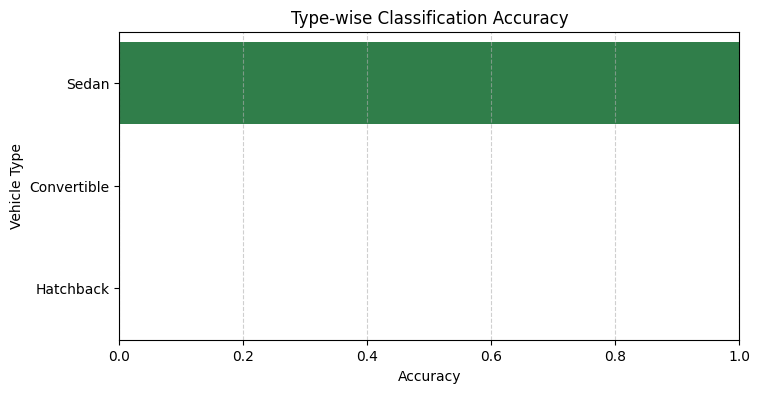

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(
    x="Accuracy",
    y="Type",
    data=type_acc_df,
    palette="Greens_r"
)

plt.title("Type-wise Classification Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Vehicle Type")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


**Normalized Confusion Matrices**

In [ ]:
cm_brand_norm = cm_brand.astype(float) / cm_brand.sum(axis=1, keepdims=True)
cm_type_norm  = cm_type.astype(float)  / cm_type.sum(axis=1, keepdims=True)


**Convert to Dataframe **

In [ ]:
brand_cm_df = pd.DataFrame(
    cm_brand_norm,
    index=brand_encoder.classes_,
    columns=brand_encoder.classes_
)

type_cm_df = pd.DataFrame(
    cm_type_norm,
    index=type_encoder.classes_,
    columns=type_encoder.classes_
)


**Export the Performance in CSV**

In [ ]:
output_dir = "/content/drive/MyDrive/Python"
import os
os.makedirs(output_dir, exist_ok=True)

brand_cm_df.to_csv(f"{output_dir}/brand_confusion_matrix_normalized.csv")
type_cm_df.to_csv(f"{output_dir}/type_confusion_matrix_normalized.csv")

brand_acc_df.to_csv(f"{output_dir}/brand_per_class_accuracy.csv", index=False)
type_acc_df.to_csv(f"{output_dir}/type_per_class_accuracy.csv", index=False)

print("✅ All evaluation CSV files exported successfully")


✅ All evaluation CSV files exported successfully


**Save Model**

In [ ]:
model.save("efficientnet_bbox_brand_type_model.keras")

**Test Data**

In [ ]:
TEST_IMAGE_DIR = "/content/drive/MyDrive/Python/test_data"
TEST_CSV_PATH  = "/content/drive/MyDrive/Python/test_data .csv"


**Load Test CSV and Encoding by Train Encoders**

In [ ]:
test_df = pd.read_csv(TEST_CSV_PATH)
print("Test samples:", len(test_df))
print(test_df.head())


Test samples: 54
   bbox_x1  bbox_x2  bbox_y1  bbox_y2     file_name
0        1        2      267      185  O9JR1MMX.jpg
1       97      104      285      210  QW4RAVFT.jpg
2      129      173      926      561  19REBJVY.jpg
3       35       53      272      190  KK8C695I.jpg
4      166      170     1076      615  AA1GHUWM.jpg


**Load and Crop Test Images**

In [ ]:
def load_and_crop_test(row):
    img_path = os.path.join(TEST_IMAGE_DIR, row["file_name"])
    img = cv2.imread(img_path)

    if img is None:
        return None

    h, w, _ = img.shape

    x1 = int(row["bbox_x1"])
    x2 = int(row["bbox_x2"])
    y1 = int(row["bbox_y1"])
    y2 = int(row["bbox_y2"])

    x_min = max(0, min(x1, x2))
    y_min = max(0, min(y1, y2))
    x_max = min(w, max(x1, x2))
    y_max = min(h, max(y1, y2))

    if x_max <= x_min or y_max <= y_min:
        return None

    crop = img[y_min:y_max, x_min:x_max]

    if crop.size == 0:
        return None

    crop = cv2.resize(crop, (224, 224))
    crop = crop / 255.0

    return crop


**Build Test Data Array**

In [ ]:
X_test = []
file_names = []
skipped = 0

for _, row in test_df.iterrows():
    img = load_and_crop_test(row)
    if img is not None:
        X_test.append(img)
        file_names.append(row["file_name"])
    else:
        skipped += 1

X_test = np.array(X_test, dtype="float32")

print("Valid test images:", X_test.shape[0])
print("Skipped test images:", skipped)


Valid test images: 53
Skipped test images: 1


**Run Predictions on Test Data**

In [ ]:
pred_brand_prob, pred_type_prob = model.predict(X_test)

pred_brand = np.argmax(pred_brand_prob, axis=1)
pred_type  = np.argmax(pred_type_prob, axis=1)

pred_brand_labels = brand_encoder.inverse_transform(pred_brand)
pred_type_labels  = type_encoder.inverse_transform(pred_type)


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


**Final Output Dataframe**

In [ ]:
final_results_df = test_df.loc[
    test_df["file_name"].isin(file_names)
].copy()

# Add predictions
final_results_df["predicted_brand"] = pred_brand_labels
final_results_df["predicted_type"]  = pred_type_labels

# Add confidence scores
final_results_df["brand_confidence"] = np.max(pred_brand_prob, axis=1)
final_results_df["type_confidence"]  = np.max(pred_type_prob, axis=1)

final_results_df.head()


,bbox_x1,bbox_x2,bbox_y1,bbox_y2,file_name,predicted_brand,predicted_type,brand_confidence,type_confidence
0,1,2,267,185,O9JR1MMX.jpg,Hyundai,Sedan,0.609551,0.790582
1,97,104,285,210,QW4RAVFT.jpg,Hyundai,Sedan,0.609461,0.790606
2,129,173,926,561,19REBJVY.jpg,Hyundai,Sedan,0.609517,0.790584
3,35,53,272,190,KK8C695I.jpg,Hyundai,Sedan,0.609504,0.790709
4,166,170,1076,615,AA1GHUWM.jpg,Hyundai,Sedan,0.609597,0.790561


**Export to CSV**

In [ ]:
output_path = "/content/drive/MyDrive/Python"
output_file = "test_predictions_with_accuracy.csv"

import os
os.makedirs(output_path, exist_ok=True)

final_results_df.to_csv(
    os.path.join(output_path, output_file),
    index=False
)

print("✅ Final output CSV saved successfully")


✅ Final output CSV saved successfully


**Saving the Model**

In [ ]:
import os

BASE_PATH = "/content/drive/MyDrive/Python"
os.makedirs(BASE_PATH, exist_ok=True)

model.save(os.path.join(BASE_PATH, "efficientnet_car_brand_type_model.keras"))

print("✅ Model saved successfully")


✅ Model saved successfully
